# Welcome to the Third Assignment of ECE421

In this assignment, wou will
* implement a feed-forward neural network (NN) that will perform classification on the IRIS dataset using functions in the `NumPy` library only.
* train a simple feed-forward NN model on FashionMNIST using `PyTorch`

This file is a Jupyter Notebook. You can double-click on section headers to show code and run each section with Shift+Enter.

# **IMPORTANT:** You will need to make a copy of this notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.

# 0. Setup

In [1]:
#@title ## 0.1 Mounting your Drive and setting up mount symlink.
#@markdown mount your Google Drive, set up mount symlink, and apt install requirements.

#@markdown Your work will be stored in a folder called `ece421_f2024_A3_folder` by default
#@markdown to prevent Colab instance timeouts from deleting your edits.

import os
from google.colab import drive
from importlib import reload
drive.mount('/content/gdrive', force_remount=True)

## setting the path parameters and creating the folder if needed
DRIVE_PATH = '/content/gdrive/MyDrive/ece421_f2024_A3_folder'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## make a symlink
SYM_PATH = '/content/ece421_f2024_A3_folder'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

!apt install the requirements
!apt update
!apt install -y --no-install-recommends \
        build-essential \
        curl \
        git \
        gnupg2 \
        make \
        cmake \
        ffmpeg \
        swig \
        libz-dev \
        unzip \
        zlib1g-dev \
        libglfw3 \
        libglfw3-dev \
        libxrandr2 \
        libxinerama-dev \
        libxi6 \
        libxcursor-dev \
        libgl1-mesa-dev \
        libgl1-mesa-glx \
        libglew-dev \
        libosmesa6-dev \
        lsb-release \
        ack-grep \
        patchelf \
        wget \
        xpra \
        xserver-xorg-dev \
        ffmpeg
!apt-get install python-opengl -y
!apt install xvfb -y

Mounted at /content/gdrive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package requirements
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
52 packages can be upgraded

## 0.2. Cloning the updated version of the repository in a new directory, *i.e.,*`ece421_f2024_A3_folder`, and installing the required python modules

We do not want to mess up with your changes to the previous assignment. So, we create a new directory, named `ece421_f2024_A3_folder`, and will clone the latest version of the assignments repository there.

In [2]:
#@title ## 0.2.1 Cloning homework repo.
#@markdown Similar to the previous assignments, you may be promped to restart your session.
#@markdown We will reset the working directory and reload the required modules
#@markdown in the following cells.

#@markdown You just need to run this cell once.


A3_SYM_PATH = '/content/gdrive/MyDrive/ece421_f2024_A3_folder'
%cd $A3_SYM_PATH

!git clone https://github.com/erfanmeskar/ece421fall24_assignments.git

REPO_PATH = '/content/gdrive/MyDrive/ece421_f2024_A3_folder/ece421fall24_assignments'
%cd $REPO_PATH

/content/gdrive/MyDrive/ece421_f2024_A3_folder
fatal: destination path 'ece421fall24_assignments' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece421_f2024_A3_folder/ece421fall24_assignments


In [3]:
#@title ### 0.2.2 Installing the requirements.

ASSIGNMENT_PATH = '/content/gdrive/MyDrive/ece421_f2024_A3_folder/ece421fall24_assignments/A3'
%cd $ASSIGNMENT_PATH
%pip install -r requirements_colab.txt

/content/gdrive/MyDrive/ece421_f2024_A3_folder/ece421fall24_assignments/A3


## 0.3. Importing the required modules

In [4]:
ASSIGNMENT_PATH = '/content/gdrive/MyDrive/ece421_f2024_A3_folder/ece421fall24_assignments/A3'
%cd $ASSIGNMENT_PATH

import os
from IPython.display import display, Markdown
from importlib import reload

from sklearn import datasets
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

import layers
import loss
import activations
import model
import util
import tests_A3

/content/gdrive/MyDrive/ece421_f2024_A3_folder/ece421fall24_assignments/A3


## 0.4 Background

The notation that we use in this assignment is different from what you had been introduced to in class. This is intentional, as we want to make sure that you fully understood the basics of neural networks and you are able to switch between different notations and modelings of neural networks. Furtheremore, adapting to the new notation serves us another purpose, as well. We want to use a modelling which is more compatible with PyTorch, as the second half od this assignment is to be done with PyTorch.


Once again, do not confuse the implementation in this assignment with the Directed Acyclic Graph (DAG) model that was introduced in class. In DAG modeling of neural networks, we clamp the weight that connects to unit to zero, if the two units in the neural network are not connected to each other. While the DAG model simplifies deriving the math for feed-forward and backpropagation, implementing the DAG would result in spending a lot of time multiplying by zero which is wasteful. Instead, in the actual implementation, we keep a set of indices for the connected units and we only some over those indices.

In particular, the figure below shows how we model a fully connected neural network. For more details, see the posted handout.

![A 3-layer fully-connected neural network](https://drive.google.com/uc?export=view&id=1u_7_ROAf8LxzLDLjv0ane8PQJFYnnsvS)

![The jth neuron in the lth layer](https://drive.google.com/uc?export=view&id=1ljHfXrZ9jSFJO0sjpQQB9JQBjksa0Xvm)

ECE421_Fall24-A3-figure-1.svg

ECE421_Fall24-A3-figure-2.svg

# 1. Implementing Feed-Forward Neural Network Using `NumPy`

In this section, you implement a feed-forward neural network (NN) that will perform classification on the IRIS dataset using functions in the `NumPy` library only.

## 1.1. Basic Network Layers

In this question you will implement the layers needed for basic classification neural networks. For each part, you will be asked to

1. derive the gradients,
2. write the matching code,
3. pass the tests.

### 1.1.1 ReLU

ReLU is a very common activation function that is typically used in the hidden layers of a neural network and is defined as
\begin{equation}
	\sigma_{\text{ReLU}}(\gamma) = \begin{cases}
		0, \text{ if }\gamma<0,\\
		\gamma, \text{ otherwise}.
	\end{cases}
\end{equation}
Note that the activation function is applied elementwise to a vector or matrix input.

Before you implement the ReLU activation function in `activations.py`, answer the following question.

  * Derive the gradient of the downstream loss with respect to the input of the ReLU activation function, $Z$. You must arrive at a solution in terms of $\partial L/\partial Y$, the gradient of the loss w.r.t.~the output of ReLU $Y = \sigma_{\text{ReLU}}(Z)$, and the batched input $Z$,i.e., where $Z \in \mathbb{R}^{m \times n}$. Include your derivation in your writeup.

	Hint: you are allowed to use operations like elementwise multiplication and/or division!

Now, implement the forward and backward passes of the ReLU activation in the script `activations.py`. Do not iterate over training examples, use batched operations.

The following tests check your implementation. We will use similar test, but with different values to test your code. We also check if you iterated over training examples or not. If instead of using batched operations, you iterate over examples, you will get 0, even if you pass all the tests.

In [ ]:
#@title Testing forward method of ReLU

reload(tests_A3)

tests_A3.test_activation_relu_forward()

Test Result: 6/6


In [ ]:
#@title Testing backward method of ReLU

reload(tests_A3)

tests_A3.test_activation_relu_backward()

Test Result: 6/6


### 1.1.2 Fully-Connected Layer


In this section, you will implement the forward and backward passes for the fully-connected layer in the \verb|layers| script. You will write the fully-connected layer for a general input $\mathbf{h}$ that contains a mini-batch of $m$ examples with $d$ features. When implementing a new layer, it is important to manually verify correctness of the forward and backward passes.

Before you implement the forward and backward passes of the fully-connected layer in \verb|layers|, answer the following question.

  * Derive the gradients of the loss $L \in \mathbb{R}$ with respect to weight matrix $W \in \mathbb{R}^{n^{[l]} \times n^{[l+1]}}$, i.e., $\partial L/\partial W$, and with respect to the bias row vector $\mathbf{b} \in \mathbb{R}^{1 \times n^{[l+1]}}$, i.e., $\partial L/\partial \mathbf{b}$, in the fully-connected layer. You will also need to take the gradient of the loss with respect to the input of the layer $\partial L/\partial X$, which will be passed to lower layers, where $X \in \mathbb{R}^{m \times n^{[l]}}$ is the batched input. Again, you must arrive at a solution that uses batched $X$ and $Z$. Please express your solution in terms of $\partial L/\partial Z$, which you have already obtained in question~\ref{q1}, where $Z=XW+\mathbf{1}^\top \mathbf{b}$ and $\mathbf{1} \in \mathbb{R}^{1 \times m}$ is a row of ones. Note that $\mathbf{1}^\top \mathbf{b}$ is a matrix whose each row is the row vector $\mathbf{b}$. So, we are adding the same bias vector to each sample during the forward pass: this is the mathematical equivalent of numpy broadcasting. Include your derivations in your writeup.

Now, implement the forward and backward passes of `FullyConnectedLayer` in `layer.py`. The backward method takes in an argument `dLdY`, the gradient of the loss with respect to the output of the layer, which is computed by higher layers and backpropagated. This should be incorporated into your gradient calculation. Do not loop over training points; use batched operations.

The following tests check your implementation. We will use similar test, but with different values to test your code. We also check if you iterated over training examples or not. If instead of using batched operations, you iterate over examples, you will get 0, even if you pass all the tests.

In [5]:
#@title Testing forward passes of fully connected layer with ReLU as its activation function

reload(tests_A3)

tests_A3.test_fully_connected_forward_relu()

Test Result: 6/6


In [6]:
#@title Testing backward passes of fully connected layer with ReLU as its activation function

reload(tests_A3)

tests_A3.test_fully_connected_backward_relu()

Test Result: 6/6


In [7]:
#@title Testing forward passes of fully connected layer with TanH as its activation function

reload(tests_A3)

tests_A3.test_fully_connected_forward_tanh()

Test Result: 11/11


In [8]:
#@title Testing backward passes of fully connected layer with TanH as its activation function

reload(tests_A3)

tests_A3.test_fully_connected_backward_tanh()

Test Result: 11/11


### 1.1.3 Softmax Activation

Next, we need to define an activation function for the output layer. The ReLU activation function returns continuous values that are (potentially) unbounded to the right. Since we are building a classifier, we want to return probabilities over classes. The softmax function has the desirable property that it outputs a probability distribution. That is, the softmax function squashes continuous values into the range $[0, 1]$ and normalizes the outputs so that they add up to $1$. For this reason, many classification neural networks use the softmax activation. The softmax activation takes in a vector $\mathbf{s}$ of $k$ un-normalized values $s_1, \ldots, s_k$ and outputs a probability distribution over the k possible classes. The forward pass of the softmax activation on input $s_i$ is
\begin{equation*}
	\sigma_i = \frac{e^{s_i}}{\sum\limits_{j=1}^k e^{s_j}},
\end{equation*}
where $k$ ranges over all elements in $\mathbf{s}$. Due to issues of numerical stability, the following modified version of this function is commonly used.
\begin{equation*}
	\sigma_i = \frac{e^{s_i -m}}{\sum\limits_{j=1}^k e^{s_j-m}},
\end{equation*}
where $m = \underset{j \in \{1,\ldots,k\}}{\max} s_j$. We strongly recommend implementing the latter formula.\\

Before you implement the forward and backward passes of the softmax activation in \verb|activations.py|, answer the following question.

  * For a single training point, derive $\partial \sigma_i/\partial s_j$ for an arbitrary $(i, j)$ pair, i.e., derive the Jacobian Matrix
	\begin{equation}
		\begin{bmatrix}
			\frac{\partial \sigma_1}{\partial s_1}, &\frac{\partial \sigma_1}{\partial s_2}, &\ldots, &\frac{\partial \sigma_1}{\partial s_k}\\
			\frac{\partial \sigma_2}{\partial s_1}, &\frac{\partial \sigma_2}{\partial s_2}, &\ldots, &\frac{\partial \sigma_2}{\partial s_k}\\
			\vdots &\vdots &\vdots &\vdots\\
			\frac{\partial \sigma_k}{\partial s_1}, &\frac{\partial \sigma_k}{\partial s_2}, &\ldots, &\frac{\partial \sigma_k}{\partial s_k}
		\end{bmatrix}.
	\end{equation}
	Include your derivation in your writeup. You do not need to use batched inputs for this question; an answer for a single training point is acceptable.

Now, implement the forward and backward passes of the softmax activation in `activations.py`. We recommend vectorizing the backward pass for efficiency.

For this question only, you are allowed to use a "for" loop over the training points in the mini-batch.

The following tests check your implementation. We will use similar test, but with different values to test your code.


In [9]:
#@title Testing forward passes of softmax

reload(tests_A3)

tests_A3.test_activation_softmax_forward()

Test Result: 6/6


In [10]:
#@title Testing backward passes of softmax

reload(tests_A3)

tests_A3.test_activation_softmax_backward()

Test Result: 6/6


### 1.1.4 Cross-Entropy Loss


For this classification network, we will be using the multi-class cross-entropy loss function
\begin{equation}
	L = -\mathbf{y} \cdot \ln \hat{\mathbf{y}}
\end{equation}
where $\mathbf{y}$ is the binary one-hot vector encoding the ground truth labels and $\hat{\mathbf{y}}$ is the network's output, a vector of probabilities over classes. Note that $\ln \hat{\mathbf{y}}$ is the elementwise natural log $\hat{\mathbf{y}}$, and $\cdot$ represents the dot product between $\mathbf{y}$ and $\ln \hat{\mathbf{y}}$. The cross-entropy loss calculated for a mini-batch of $m$ samples is
\begin{equation}
	L = -\frac{1}{m}\sum\limits_{i=1}^m \mathbf{y}_i \cdot \ln \hat{\mathbf{y}}_i.
\end{equation}
Let $Y \in \mathbb{R}^{m \times k}$ and $\hat{Y} \in \mathbb{R}^{m \times k}$ be the one-hot labels and network outputs for the $m$ samples, stacked in a matrix. Then, $ \mathbf{y}_i$ and $\hat{\mathbf{y}}_i$ in the expression above are just the $i_{\text{th}}$ rows of $Y$ and $\hat{Y}$.

Before you implement the forward and backward passes of the cross-entropy cost, answer the following question.

  * Derive $\partial L/ \partial \hat{Y}$ the gradient of the cross-entropy cost with respect to the network's predictions, $\hat{Y}$. You must use batched inputs. Include your derivation in your writeup.

  Hint: You are allowed to use operations like elementwise multiplication and/or division!

Now, implement the forward and backward passes of `CrossEntropyLoss` in `loss.py`.

Do not iterate over training examples; use batched operations.

The following tests check your implementation. We will use similar test, but with different values to test your code. We also check if you iterated over training examples or not. If instead of using batched operations, you iterate over examples, you will get 0, even if you pass all the tests.


In [11]:
#@title Testing forward passes of cross_entropy

reload(tests_A3)

tests_A3.test_loss_cross_entropy_forward()

Test Result: 6/6


In [12]:
#@title Testing backward passes of cross_entropy

reload(tests_A3)

tests_A3.test_loss_cross_entropy_backward()

Test Result: 6/6


## 1.2. Two-Layer Fully Connected Networks

Now, you will use the methods you've written to train a two-layer network (also referred to as a one-hidden layer network). You will use the Iris Dataset, which contains $4$ features for $3$ different classes of irises.

### 1.2.1. Implementing Fully Connected Layer

Fill in the forward, backward, and predict methods for the `NeuralNetworkModel` class in`model.py`.

We have provided you with several other classes that are critical for the training process.

  * The data loader (in `util.py`), which is responsible for loading batches of data that will be fed to your model during training. You may wish to alter the data loader to handle data pre-processing.

  * The stochastic gradient descent optimizer (in `optimizer.py`), which performs the gradient updates and optionally incorporates a momentum term.

  * A logger (in `util.py`), which saves hyperparameters and learned parameters and plots the loss as your model trains.

Outputs will be saved to the folder `experiments/`. You can change the name of the folder a given run saves to by changing the parameter called model name. Be careful about overwriting folders; if you forget to change the name and perform a run with identical hyperparameters, your previous run will be overwritten!

In [13]:
#@title Testing if you find the correct gradients by comparing your output to our numerical approach
#@markdown This tests your implemented activation functions

reload(tests_A3)

tests_A3.test_gradients_activation()

Relative error for each test case is expected to be less than 1e-8
Relative error for relu activation: 1.538884632208583e-11
Relative error for softmax activation: 1.657605952842582e-10
Test Result: 2/2


In [14]:
#@title OPTIONAL: Testing your implemented sigmoid activation function (No Extra Credit)

reload(tests_A3)

tests_A3.test_gradients_optional_sigmoid()

Relative error for each test case is expected to be less than 1e-8
Relative error for sigmoid activation: 4.693987086762986e-11
* Test Result for Sigmoid Gradients (Optional, no extra credit):  1/1


In [15]:
#@title Testing if you find the correct gradients by comparing your output to our numerical approach
#@markdown This tests your implemented fully connected layer

reload(tests_A3)

tests_A3.test_gradients_fully_connected_layer()

Relative error for each test case is expected to be less than 1e-8
Relative error for W: 2.712419431090583e-11
Relative error for b: 4.428462408252424e-11
Test Result: 2/2


## 1.2.2. Hyperparameter Tuning (in a very small scale)

In the following cell, we Train a 2-layer neural network on the Iris Dataset. Feel free to modify the following hyperparameters.

  * Learning rate
  * Momemntum hyperparameter
  * Activation functions
  * Hidden layer size (number of units per hidden layer)

Interestingly, random seed can also be considered as a hyperparameter. However, for consistency and reproducibility, let's not change it in this assignment.

answer the following question.

  * Try at least 3 different combinations of the above hyperparameters. Report the results of your exploration, including the values of the parameters you explored and which set of parameters gave the best test error. Provide plots showing the loss versus iterations for your best model and report your final test error.

In [16]:
#@title Training a two-layer feed forward neural network

# An attribute dictionary is exactly like a dictionary,
# except you can access the values as attributes rather than keys.
class AttrDict(dict):
  def __init__(self, *args, **kwargs):
    super(AttrDict, self).__init__(*args, **kwargs)
    self.__dict__ = self


# Define layer arguments
fc1 = AttrDict({"activation": "relu", "n_out": 5})
fc_out = AttrDict({"activation": "softmax", "n_out": None}) # n_out is not defined for last layer. This will be set by the dataset.
layer_args = [fc1, fc_out]

# Define model, data, and logger arguments
optimizer_args = AttrDict({"lr": 0.01, "momentum_hyperparameter": 0.9})
model_args = AttrDict({"loss": "cross_entropy", "layer_args": layer_args,
                       "optimizer_args": optimizer_args, "seed": 0})
data_args = AttrDict({"name": "iris", "batch_size": 25})
log_args = AttrDict({"save": True, "plot": True, "save_dir": "experiments/"})

# Set random seed. Random seed must be set before importing other modules.
import numpy as np
np.random.seed(model_args.seed)

# Define model name for saving.
model_name = f'{len(layer_args)}layers' + f'_{fc1["n_out"]}' + f'-lr{optimizer_args.lr}' +\
             f'_mom{optimizer_args.momentum_hyperparameter}' + f'_seed{model_args.seed}'

# Initialize logger, model, and dataset.
from model import NeuralNetworkModel
from util import Dataset, Logger
logger = Logger(model_name=model_name, model_args=model_args, data_args=data_args,
                save=log_args.save, plot=log_args.plot, save_dir=log_args.save_dir)
model = NeuralNetworkModel(loss=model_args.loss, layer_args=model_args.layer_args,
                           optimizer_args=model_args.optimizer_args, logger=logger)
dataset = Dataset(
    np.load('datasets/iris/iris_train_data.npy'),
    np.load('datasets/iris/iris_train_labels.npy'),
    data_args.batch_size,
    np.load('datasets/iris/iris_val_data.npy'),
    np.load('datasets/iris/iris_val_labels.npy'),
    np.load('datasets/iris/iris_test_data.npy'),
    np.load('datasets/iris/iris_test_labels.npy')
    )

# Train model!
epochs = 100
print(f"Training feed forward neural network on {data_args.name} with SGD for {epochs} epochs...")
model.train(dataset, epochs=epochs)
test_log = model.test(dataset)

Training feed forward neural network on iris with SGD for 100 epochs...


100%|██████████| 5/5 [00:00<00:00, 833.89it/s]


Epoch 0:
	 Training Loss: 11.116, Training Accuracy: 0.472, Val Loss: 7.4187, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1067.58it/s]


Epoch 1:
	 Training Loss: 10.9313, Training Accuracy: 0.584, Val Loss: 7.4978, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1348.48it/s]


Epoch 2:
	 Training Loss: 10.892, Training Accuracy: 0.6, Val Loss: 7.4088, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 964.56it/s]


Epoch 3:
	 Training Loss: 8.209, Training Accuracy: 0.704, Val Loss: 7.4328, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 979.29it/s]


Epoch 4:
	 Training Loss: 11.7567, Training Accuracy: 0.576, Val Loss: 7.4241, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 991.66it/s]


Epoch 5:
	 Training Loss: 9.091, Training Accuracy: 0.672, Val Loss: 7.3941, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 924.34it/s]


Epoch 6:
	 Training Loss: 9.0769, Training Accuracy: 0.672, Val Loss: 7.385, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1480.31it/s]


Epoch 7:
	 Training Loss: 9.079, Training Accuracy: 0.672, Val Loss: 7.3827, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 979.57it/s]


Epoch 8:
	 Training Loss: 9.9569, Training Accuracy: 0.64, Val Loss: 7.3804, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 665.47it/s]


Epoch 9:
	 Training Loss: 9.9553, Training Accuracy: 0.64, Val Loss: 7.3787, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 884.69it/s]


Epoch 10:
	 Training Loss: 9.9542, Training Accuracy: 0.64, Val Loss: 7.3775, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1060.67it/s]


Epoch 11:
	 Training Loss: 8.1859, Training Accuracy: 0.704, Val Loss: 7.3768, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1439.86it/s]


Epoch 12:
	 Training Loss: 9.069, Training Accuracy: 0.672, Val Loss: 7.3762, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1497.22it/s]


Epoch 13:
	 Training Loss: 10.8386, Training Accuracy: 0.608, Val Loss: 7.3757, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1382.62it/s]


Epoch 14:
	 Training Loss: 11.7205, Training Accuracy: 0.576, Val Loss: 7.3753, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 878.24it/s]


Epoch 15:
	 Training Loss: 9.0678, Training Accuracy: 0.672, Val Loss: 7.375, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1019.47it/s]


Epoch 16:
	 Training Loss: 10.8361, Training Accuracy: 0.608, Val Loss: 7.3748, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 583.92it/s]


Epoch 17:
	 Training Loss: 8.1871, Training Accuracy: 0.704, Val Loss: 7.3745, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 639.92it/s]


Epoch 18:
	 Training Loss: 9.068, Training Accuracy: 0.672, Val Loss: 7.3743, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 895.45it/s]


Epoch 19:
	 Training Loss: 8.1834, Training Accuracy: 0.704, Val Loss: 7.3742, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1677.72it/s]


Epoch 20:
	 Training Loss: 10.836, Training Accuracy: 0.608, Val Loss: 7.374, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 922.72it/s]


Epoch 21:
	 Training Loss: 9.0677, Training Accuracy: 0.672, Val Loss: 7.3737, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 957.87it/s]


Epoch 22:
	 Training Loss: 10.8353, Training Accuracy: 0.608, Val Loss: 7.3735, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 868.46it/s]


Epoch 23:
	 Training Loss: 9.9514, Training Accuracy: 0.64, Val Loss: 7.3734, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1083.41it/s]


Epoch 24:
	 Training Loss: 8.1826, Training Accuracy: 0.704, Val Loss: 7.3733, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 982.18it/s]


Epoch 25:
	 Training Loss: 8.1828, Training Accuracy: 0.704, Val Loss: 7.3731, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 880.64it/s]


Epoch 26:
	 Training Loss: 9.0671, Training Accuracy: 0.672, Val Loss: 7.373, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 720.47it/s]


Epoch 27:
	 Training Loss: 9.9539, Training Accuracy: 0.64, Val Loss: 7.3729, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 811.69it/s]


Epoch 28:
	 Training Loss: 9.9511, Training Accuracy: 0.64, Val Loss: 7.3727, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 753.56it/s]


Epoch 29:
	 Training Loss: 9.9509, Training Accuracy: 0.64, Val Loss: 7.3727, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 824.90it/s]


Epoch 30:
	 Training Loss: 9.0664, Training Accuracy: 0.672, Val Loss: 7.3725, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1283.68it/s]


Epoch 31:
	 Training Loss: 9.9502, Training Accuracy: 0.64, Val Loss: 7.3724, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 859.74it/s]


Epoch 32:
	 Training Loss: 9.9503, Training Accuracy: 0.64, Val Loss: 7.3723, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 948.12it/s]


Epoch 33:
	 Training Loss: 10.8343, Training Accuracy: 0.608, Val Loss: 7.3722, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 904.76it/s]


Epoch 34:
	 Training Loss: 8.1819, Training Accuracy: 0.704, Val Loss: 7.3721, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 994.01it/s]


Epoch 35:
	 Training Loss: 9.0663, Training Accuracy: 0.672, Val Loss: 7.372, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 732.55it/s]


Epoch 36:
	 Training Loss: 10.8343, Training Accuracy: 0.608, Val Loss: 7.372, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 847.71it/s]


Epoch 37:
	 Training Loss: 9.9503, Training Accuracy: 0.64, Val Loss: 7.3719, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 943.56it/s]


Epoch 38:
	 Training Loss: 9.95, Training Accuracy: 0.64, Val Loss: 7.3718, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 997.69it/s]


Epoch 39:
	 Training Loss: 11.7183, Training Accuracy: 0.576, Val Loss: 7.3718, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 765.30it/s]


Epoch 40:
	 Training Loss: 9.0661, Training Accuracy: 0.672, Val Loss: 7.3717, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 958.83it/s]


Epoch 41:
	 Training Loss: 9.0656, Training Accuracy: 0.672, Val Loss: 7.3716, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 829.11it/s]


Epoch 42:
	 Training Loss: 9.0669, Training Accuracy: 0.672, Val Loss: 7.3716, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 994.24it/s]


Epoch 43:
	 Training Loss: 9.9503, Training Accuracy: 0.64, Val Loss: 7.3715, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 997.03it/s]


Epoch 44:
	 Training Loss: 9.0656, Training Accuracy: 0.672, Val Loss: 7.3715, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 675.09it/s]


Epoch 45:
	 Training Loss: 9.0677, Training Accuracy: 0.672, Val Loss: 7.3714, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1117.05it/s]


Epoch 46:
	 Training Loss: 9.0657, Training Accuracy: 0.672, Val Loss: 7.3714, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 953.08it/s]


Epoch 47:
	 Training Loss: 9.0657, Training Accuracy: 0.672, Val Loss: 7.3714, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 883.42it/s]


Epoch 48:
	 Training Loss: 9.0661, Training Accuracy: 0.672, Val Loss: 7.3713, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 875.02it/s]


Epoch 49:
	 Training Loss: 9.0656, Training Accuracy: 0.672, Val Loss: 7.3712, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 905.00it/s]


Epoch 50:
	 Training Loss: 11.718, Training Accuracy: 0.576, Val Loss: 7.3711, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 912.76it/s]


Epoch 51:
	 Training Loss: 9.9497, Training Accuracy: 0.64, Val Loss: 7.3711, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1049.57it/s]


Epoch 52:
	 Training Loss: 9.9493, Training Accuracy: 0.64, Val Loss: 7.371, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 482.79it/s]


Epoch 53:
	 Training Loss: 9.0652, Training Accuracy: 0.672, Val Loss: 7.371, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 560.84it/s]


Epoch 54:
	 Training Loss: 9.9494, Training Accuracy: 0.64, Val Loss: 7.3709, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 860.94it/s]


Epoch 55:
	 Training Loss: 11.7176, Training Accuracy: 0.576, Val Loss: 7.3709, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 876.66it/s]


Epoch 56:
	 Training Loss: 9.9496, Training Accuracy: 0.64, Val Loss: 7.3709, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 871.49it/s]


Epoch 57:
	 Training Loss: 8.1811, Training Accuracy: 0.704, Val Loss: 7.3708, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 810.37it/s]


Epoch 58:
	 Training Loss: 11.7175, Training Accuracy: 0.576, Val Loss: 7.3708, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 841.45it/s]


Epoch 59:
	 Training Loss: 10.8333, Training Accuracy: 0.608, Val Loss: 7.3707, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 781.24it/s]


Epoch 60:
	 Training Loss: 10.8338, Training Accuracy: 0.608, Val Loss: 7.3707, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 635.67it/s]


Epoch 61:
	 Training Loss: 9.067, Training Accuracy: 0.672, Val Loss: 7.3707, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 553.57it/s]


Epoch 62:
	 Training Loss: 9.9495, Training Accuracy: 0.64, Val Loss: 7.3707, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 839.40it/s]


Epoch 63:
	 Training Loss: 10.8333, Training Accuracy: 0.608, Val Loss: 7.3707, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 770.30it/s]


Epoch 64:
	 Training Loss: 9.9491, Training Accuracy: 0.64, Val Loss: 7.3706, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 736.23it/s]


Epoch 65:
	 Training Loss: 9.065, Training Accuracy: 0.672, Val Loss: 7.3706, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 762.96it/s]


Epoch 66:
	 Training Loss: 9.9504, Training Accuracy: 0.64, Val Loss: 7.3706, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1317.06it/s]


Epoch 67:
	 Training Loss: 9.9493, Training Accuracy: 0.64, Val Loss: 7.3706, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 843.79it/s]


Epoch 68:
	 Training Loss: 11.7174, Training Accuracy: 0.576, Val Loss: 7.3706, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 783.72it/s]


Epoch 69:
	 Training Loss: 9.0662, Training Accuracy: 0.672, Val Loss: 7.3705, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 902.16it/s]


Epoch 70:
	 Training Loss: 9.9502, Training Accuracy: 0.64, Val Loss: 7.3705, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 550.29it/s]


Epoch 71:
	 Training Loss: 8.181, Training Accuracy: 0.704, Val Loss: 7.3705, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 754.29it/s]


Epoch 72:
	 Training Loss: 11.7172, Training Accuracy: 0.576, Val Loss: 7.3705, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1004.91it/s]


Epoch 73:
	 Training Loss: 10.8333, Training Accuracy: 0.608, Val Loss: 7.3704, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 795.13it/s]


Epoch 74:
	 Training Loss: 9.9489, Training Accuracy: 0.64, Val Loss: 7.3703, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1081.17it/s]


Epoch 75:
	 Training Loss: 9.95, Training Accuracy: 0.64, Val Loss: 7.3703, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 724.91it/s]


Epoch 76:
	 Training Loss: 9.0649, Training Accuracy: 0.672, Val Loss: 7.3702, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 734.04it/s]


Epoch 77:
	 Training Loss: 11.7171, Training Accuracy: 0.576, Val Loss: 7.3702, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 859.14it/s]


Epoch 78:
	 Training Loss: 9.0648, Training Accuracy: 0.672, Val Loss: 7.3702, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 696.64it/s]


Epoch 79:
	 Training Loss: 10.833, Training Accuracy: 0.608, Val Loss: 7.3701, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 671.15it/s]


Epoch 80:
	 Training Loss: 11.717, Training Accuracy: 0.576, Val Loss: 7.3701, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 764.55it/s]


Epoch 81:
	 Training Loss: 9.949, Training Accuracy: 0.64, Val Loss: 7.3701, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 854.03it/s]


Epoch 82:
	 Training Loss: 9.0645, Training Accuracy: 0.672, Val Loss: 7.3701, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 825.94it/s]


Epoch 83:
	 Training Loss: 8.1804, Training Accuracy: 0.704, Val Loss: 7.3701, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 886.71it/s]


Epoch 84:
	 Training Loss: 10.8329, Training Accuracy: 0.608, Val Loss: 7.37, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 647.51it/s]


Epoch 85:
	 Training Loss: 9.0644, Training Accuracy: 0.672, Val Loss: 7.37, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 770.08it/s]


Epoch 86:
	 Training Loss: 9.9488, Training Accuracy: 0.64, Val Loss: 7.37, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 788.97it/s]


Epoch 87:
	 Training Loss: 10.8328, Training Accuracy: 0.608, Val Loss: 7.37, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 795.79it/s]


Epoch 88:
	 Training Loss: 9.0646, Training Accuracy: 0.672, Val Loss: 7.37, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1211.39it/s]


Epoch 89:
	 Training Loss: 9.9486, Training Accuracy: 0.64, Val Loss: 7.3699, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1386.09it/s]


Epoch 90:
	 Training Loss: 9.9493, Training Accuracy: 0.64, Val Loss: 7.3699, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 823.48it/s]


Epoch 91:
	 Training Loss: 9.9485, Training Accuracy: 0.64, Val Loss: 7.3699, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 876.59it/s]


Epoch 92:
	 Training Loss: 11.7169, Training Accuracy: 0.576, Val Loss: 7.3699, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 867.95it/s]


Epoch 93:
	 Training Loss: 9.9485, Training Accuracy: 0.64, Val Loss: 7.3699, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 857.03it/s]


Epoch 94:
	 Training Loss: 9.0644, Training Accuracy: 0.672, Val Loss: 7.3699, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 481.63it/s]


Epoch 95:
	 Training Loss: 9.0646, Training Accuracy: 0.672, Val Loss: 7.3698, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 447.16it/s]


Epoch 96:
	 Training Loss: 11.717, Training Accuracy: 0.576, Val Loss: 7.3698, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1043.88it/s]


Epoch 97:
	 Training Loss: 9.0643, Training Accuracy: 0.672, Val Loss: 7.3698, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 799.71it/s]


Epoch 98:
	 Training Loss: 9.9487, Training Accuracy: 0.64, Val Loss: 7.3698, Val Accuracy: 0.7333


100%|██████████| 5/5 [00:00<00:00, 1529.54it/s]


Epoch 99:
	 Training Loss: 8.1801, Training Accuracy: 0.704, Val Loss: 7.3698, Val Accuracy: 0.7333

Test Loss: 7.1849, Test Accuracy: 0.74


# 2. Implementing Neural Networks Using `PyTorch`

This part of the assignment is designed to get you familiar with how engineerings in the real world train neural network systems.

This notebook will have the following components:

  1. Understanding the basics of Pytorch (no deliverables)
  2. Training a simple neural network on MNIST (Deliverable = training graphs)

You will also get practice being an ML engineer by reading documentation and using it to implement models. The first section of this notebook will cover an outline of what you need to know -- we are confident that you can find the rest on your own.

In [17]:
#@title ## 2.0. Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

## 2.1. Understanding Pytorch

Pytorch is based on the "autograd" paradigm. Essentially, you perform operations on multi-dimensional arrays like in numpy, except pytorch will automatically handle gradient tracking. In this section you will understand how to use pytorch.

This section should help you understand the full pipeline of creating and training a model in pytorch. Feel free to re-use code from this section in the assigned tasks.

Content in this section closely follows this pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/intro.html

In [ ]:
#@title ## 2.1.1 Tensors

#@markdown Tensors can be created from numpy data or by using pytorch directly.

#@markdown They also support slicing and math operations very similar to numpy.

#@markdown See the examples in this cell.

data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)

shape = (2,3,)
rand_tensor = torch.rand(shape)
np_rand_array = rand_tensor.numpy()

print(f"Tensor from np: \n {x_np} \n")
print(f"Rand Tensor: \n {rand_tensor} \n")
print(f"Rand Numpy Array: \n {np_rand_array} \n")

# Slicing
tensor = torch.ones(4, 4)
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])

# Matrix Operations multiplication
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

# Getting a single item
scalar = torch.sum(y1) # sums all elements
item = scalar.item() # converting single tensor value to a Python number
print("Sum as a tensor:", scalar, ", Sum as an item:", item)

# tensor addition
x = torch.ones(4, 3)
y = torch.ones(4, 3)
print(x + y)

# tensor multiplication
x = torch.rand(4, 3)
y = torch.ones(4, 3)
print(x * y)

# Provide output tensor as argument
result = torch.ones(4,3)
# specify a pre-allocated tensor where the result of the operation will be stored
torch.add(x, y, out = result)
print(result)

# resize and reshape tensors
x = torch.randn(4, 3)
y = x.view(12)
z = x.view(-1, 4)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

Tensor from np: 
 tensor([[1, 2],
        [3, 4]]) 

Rand Tensor: 
 tensor([[0.2871, 0.2241, 0.4341],
        [0.4298, 0.8472, 0.5758]]) 

Rand Numpy Array: 
 [[0.28712815 0.2240519  0.43410254]
 [0.42980546 0.8471543  0.5757566 ]] 

First row:  tensor([1., 1., 1., 1.])
First column:  tensor([1., 1., 1., 1.])
Sum as a tensor: tensor(64.) , Sum as an item: 64.0
tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])
tensor([[0.9155, 0.2129, 0.8663],
        [0.4605, 0.1286, 0.0233],
        [0.3237, 0.2994, 0.0014],
        [0.5030, 0.7554, 0.0610]])
tensor([[1.9155, 1.2129, 1.8663],
        [1.4605, 1.1286, 1.0233],
        [1.3237, 1.2994, 1.0014],
        [1.5030, 1.7554, 1.0610]])
torch.Size([4, 3]) torch.Size([12]) torch.Size([3, 4])


In [ ]:
#@title ## 2.1.2. Autograd
#@markdown This small section shows you how pytorch computes gradients.

#@markdown When we create tenors, we can set `requires_grad` to be true to indicate
#@markdown that we are using gradients. For most of the work that you actually do,
#@markdown you will use the `nn` package, which automatically sets all parameter
#@markdown tensors to have `requires_grad=True`.

#@markdown This cell is an example of computing the gradient for a single data
#@markdown point in logistic regression using pytorch's autograd.


x = torch.ones(5)  # input tensor
y = torch.zeros(1) # label
w = torch.randn(5, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
pred = torch.sigmoid(torch.matmul(x, w) + b)
loss = torch.nn.functional.binary_cross_entropy(pred, y)
loss.backward() # Computers gradients
print("W gradient:", w.grad)
print("b gradient:", b.grad)

# when we want to actually take an update step, we can use optimizers:
optimizer = torch.optim.SGD([w, b], lr=0.1)
print("Weight before", w)
optimizer.step() # use the computed gradients to update
# Print updated weights
print("Updated weight", w)

# Performing operations with gradients enabled is slow...
# You can disable gradient computation using the following enclosure:
with torch.no_grad():
    # Perform operations without gradients
    ...

In [ ]:
#@title ## 2.1.3. Devices

#@markdown Pytorch supports accelerating computation using GPUs which are available on google colab. To use a GPU on google colab, go to runtime -> change runtime type -> select GPU.

#@markdown Note that there is some level of strategy for knowing when to use which runtime type. Colab will kick users off of GPU for a certain period of time if you use it too much. Thus, its best to run simple models and prototype to get everything working on CPU, then switch the instance type over to GPU for training runs and parameter tuning.

#@markdown Its best practice to make sure your code works on any device (GPU or CPU) for pytorch, but note that numpy operations can only run on the CPU. Here is a standard flow for using GPU acceleration:


# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# Next create your tensors
tensor = torch.zeros(4, 4, requires_grad=True)
# Move the tensor to the device you want to use
tensor = tensor.to(device)

# Perform whatever operations you want.... (often this will involve gradients)
# These operations will be accelerated by GPU.
tensor = 10*(tensor + 1)

# bring the tensor back to CPU, first detaching it from any gradient computations
tensor = tensor.detach().cpu()

tensor_np = tensor.numpy() # Convert to numpy if you want to perform numpy operations.

Using device cpu


In [ ]:
#@title ## 2.1.4. The NN Package

#@markdown Pytorch implements composable blocks in `Module` classes. All layers
#@markdown and modules in pytorch inherit from `nn.Module`. When you make a module
#@markdown you need to implement two functions: `__init__(self, *args, **kwargs)`
#@markdown and `foward(self, *args, **kwargs)`. Modules also have some nice helper
#@markdown functions, namely `parameters` which will recursively return all of the
#@markdown parameters. Here is an example of a logistic regression model:

class Perceptron(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.layer = nn.Linear(in_dim, 1) # This is a linear layer, it computes Xw + b

  def forward(self, x):
    return torch.sigmoid(self.layer(x)).squeeze(-1)

perceptron = Perceptron(10)
perceptron = perceptron.to(device) # Move all the perceptron's tensors to the device
print("Parameters", list(perceptron.parameters()))

In [ ]:
#@title ## 2.1.5. Datasets

#@markdown Pytorch has nice interfaces for using datasets.

#@markdown Suppose we create a logistic regression dataset as follows:

c1_x1, c1_x2 = np.random.multivariate_normal([-2.5,3], [[1, 0.3],[0.3, 1]], 100).T
c2_x1, c2_x2 = np.random.multivariate_normal([1,1], [[2, 1],[1, 2]], 100).T
c1_X = np.vstack((c1_x1, c1_x2)).T
c2_X = np.vstack((c2_x1, c2_x2)).T
train_X = np.concatenate((c1_X, c2_X))
train_y = np.concatenate((np.zeros(100), np.ones(100)))
# Shuffle the data
permutation = np.random.permutation(train_X.shape[0])
train_X = train_X[permutation, :]
train_y = train_y[permutation]
# Plot the data
plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.axis('equal')
plt.show()

In [ ]:
#@title ### 2.1.5.1 Datasets and DataLoader

#@markdown We can then create a pytorch dataset object as follows. Often times,
#@markdown the default pytorch datasets will create these objects for you. Then,
#@markdown we can apply dataloaders to iterate over the dataset in batches.

dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
# We can create a dataloader that iterates over the dataset in batches.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
for x, y in dataloader:
    print("Batch x:", x)
    print("Batch y:", y)
    break

# Clean up the dataloader as we make a new one later
del dataloader

In [ ]:
#@title ## 2.1.6. Training Loop Example

#@markdown Here is an example of training a full logistic regression model in
#@markdown pytorch. Note the extensive use of modules -- modules can be used for
#@markdown storing networks, computation steps etc.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 10
batch_size = 10
learning_rate = 0.01

num_features = dataset[0][0].shape[0]
model = Perceptron(num_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
for epoch in range(epochs):
    training_losses = []
    for x, y in tqdm(dataloader, unit="batch"):
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))

# We can run predictions on the data to determine the final accuracy.
with torch.no_grad():
    model.eval() # Put model in eval mode
    num_correct = 0
    for x, y in dataloader:
        x, y = x.float().to(device), y.float().to(device)
        pred = model(x)
        num_correct += torch.sum(torch.round(pred) == y).item()
    print("Final Accuracy:", num_correct / len(dataset))
    model.train() # Put model back in train mode

## 2.2. Task: MLP For FashionMNIST
Now you will train a multi-layer perceptron model on an MNIST-like dataset. Your deliverables are as follows:

1. Code for training an MLP on MNIST (can be in code appendix, tagged in your submission).
2. A plot of the training loss and validation loss for each epoch of training after trainnig for at least 8 epochs.
3. A plot of the training and validation accuracy, showing that it is at least 82% for validation by the end of training.

Below we will create the training and validation datasets for you, and provide a very basic skeleton of the code. Please leverage the example training loop from above.

Some pytorch components you should definitely use:
1. `nn.Linear`
2. Some activation function like `nn.ReLU`
3. `nn.CrossEntropyLoss`: if you choose to use `nn.CrossEntropyLoss` or `F.cross_entropy`, DO NOT add an explicit softmax layer in your neural network. PyTorch devs found it more numerically stable to combine softmax and cross entropy loss into a single module and if you explicitly attach a softmax layer at the end of your model, you would unintentionally be applying it twice, which can degrade performance.

Here are challenges you will need to overcome:
1. The data is default configured in image form i.e. (1 x 28 x 28), versus one feature vector. You will need to reshape it somewhere to feed it in as vector to the MLP. There are many ways of doing this.
2. You need to write code for plotting.
3. You need to find appropriate hyper-parameters to achieve good accuracy.

Your underlying model must be fully connected or dense, and may not have convolutions etc., but you can use anything in torch.optim or any layers in torch.nn besides nn.Linear that do not have weights.

In [19]:
# Creating the datasets
transform = torchvision.transforms.ToTensor() # feel free to modify this as you see fit.

training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

validation_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

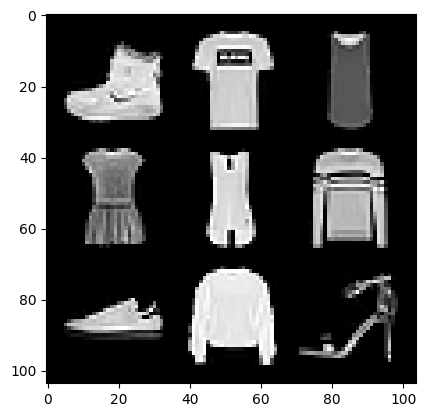

In [ ]:
#@title FasionMNIST visualization
#@markdown Before training a neural network, let's visualize our data first!
#@markdown Running the cell below will display the first 9 images in a 3 by 3 grid.

images = [training_data[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

Using device cuda


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 1, Train Loss: 0.9404, Train Acc: 0.6730, Val Loss: 0.6121, Val Acc: 0.7814


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 2, Train Loss: 0.5445, Train Acc: 0.8097, Val Loss: 0.5972, Val Acc: 0.7809


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 3, Train Loss: 0.4779, Train Acc: 0.8314, Val Loss: 0.5242, Val Acc: 0.8022


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 4, Train Loss: 0.4417, Train Acc: 0.8447, Val Loss: 0.4684, Val Acc: 0.8323


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 5, Train Loss: 0.4146, Train Acc: 0.8538, Val Loss: 0.4451, Val Acc: 0.8407


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 6, Train Loss: 0.3947, Train Acc: 0.8591, Val Loss: 0.4161, Val Acc: 0.8525


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 7, Train Loss: 0.3790, Train Acc: 0.8654, Val Loss: 0.3983, Val Acc: 0.8596


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 8, Train Loss: 0.3652, Train Acc: 0.8700, Val Loss: 0.4158, Val Acc: 0.8503


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 9, Train Loss: 0.3529, Train Acc: 0.8740, Val Loss: 0.4265, Val Acc: 0.8444


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 10, Train Loss: 0.3432, Train Acc: 0.8770, Val Loss: 0.4180, Val Acc: 0.8461


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 11, Train Loss: 0.3337, Train Acc: 0.8795, Val Loss: 0.3806, Val Acc: 0.8658


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 12, Train Loss: 0.3258, Train Acc: 0.8824, Val Loss: 0.3771, Val Acc: 0.8626


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 13, Train Loss: 0.3164, Train Acc: 0.8850, Val Loss: 0.3767, Val Acc: 0.8660


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 14, Train Loss: 0.3087, Train Acc: 0.8876, Val Loss: 0.3762, Val Acc: 0.8655


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 15, Train Loss: 0.3010, Train Acc: 0.8905, Val Loss: 0.3739, Val Acc: 0.8654


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 16, Train Loss: 0.2951, Train Acc: 0.8919, Val Loss: 0.3745, Val Acc: 0.8586


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 17, Train Loss: 0.2902, Train Acc: 0.8938, Val Loss: 0.4155, Val Acc: 0.8407


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 18, Train Loss: 0.2840, Train Acc: 0.8962, Val Loss: 0.3664, Val Acc: 0.8680


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 19, Train Loss: 0.2785, Train Acc: 0.8984, Val Loss: 0.3498, Val Acc: 0.8728


  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 20, Train Loss: 0.2741, Train Acc: 0.9003, Val Loss: 0.3822, Val Acc: 0.8653


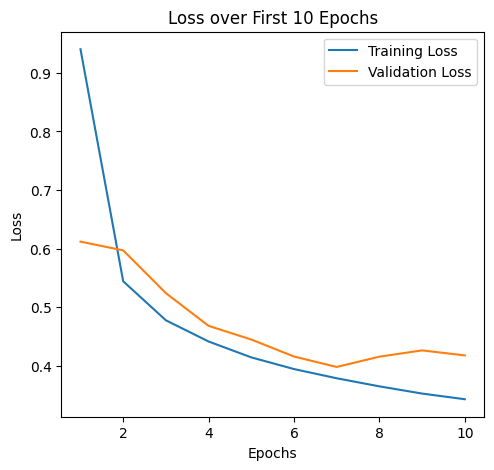

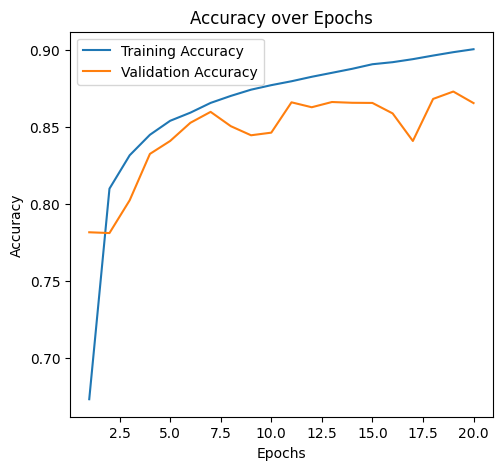

Final Validation Accuracy is 86.53%


In [30]:
import torch.nn.functional as F

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

# Dataloaders for batch processing
batch_size = 64
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)

# Define our 3-layer artificial neural network (MLP) model
class FashionMLP(nn.Module):
    def __init__(self):
        super(FashionMLP, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 128)  # Input: 784 (28x28), Output: 128 neurons
        self.layer2 = nn.Linear(128, 64)       # Hidden layer: 128 -> 64 neurons
        self.layer3 = nn.Linear(64, 10)        # Output layer: 64 -> 10 (Use 10 as final output layer since there are 10 classes in FashionMNIST)

    def forward(self, img):
        flattened = img.view(-1, 28 * 28)  # Flatten the image into a vector
        activation1 = F.relu(self.layer1(flattened))  # First hidden layer, apply Relu activation function
        activation2 = F.relu(self.layer2(activation1))  # Second hidden layer, apply Relu activation function
        output = self.layer3(activation2)  # Output layer, no activation function
        return output

# Instantiate the model and move it to the appropriate device
model = FashionMLP().to(device)

# Optimizer (SGD) and loss function (cross entropy)
learning_rate = 0.03
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

epochs = 20  # Increased epochs to try to achieve 82% accuracy
train_losses = [] # store training losses for plotting
val_losses = [] # store validation losses for plotting
train_accuracies = [] # store training accuracies for plotting
val_accuracies = [] # store validation accuracies for plotting

# Training loop
model.train()  # Put model in training mode
for epoch in range(epochs):
    training_losses = []
    correct_train = 0
    total_train = 0
    for x, y in tqdm(train_loader, unit="batch"):
        x, y = x.to(device), y.to(device)  # Move data to the appropriate device
        optimizer.zero_grad()  # Clear previous gradients
        pred = model(x)  # Forward pass
        loss = loss_func(pred, y)  # Compute loss by nn.CrossEntropyLoss
        loss.backward()  # Backpropagate to compute gradients
        optimizer.step()  # Update model parameters

        # Track training loss
        training_losses.append(loss.item())

        # Compute training accuracy
        _, predicted = torch.max(pred.data, 1)
        total_train += y.size(0)
        correct_train += (predicted == y).sum().item()

    train_losses.append(np.mean(training_losses))
    train_accuracies.append(correct_train / total_train)

    # Compute the validation loss with nn.CrossEntropyLoss()
    model.eval()  # Set model to evaluation mode
    validation_losses = [] # store the validation losses for plot
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model(x_val)  # Forward pass for validation data
            val_loss = loss_func(pred_val, y_val) # Apply cross entropy loss function to it
            validation_losses.append(val_loss.item())

            # Compute validation accuracy
            _, predicted_val = torch.max(pred_val.data, 1)
            total_val += y_val.size(0)
            correct_val += (predicted_val == y_val).sum().item()

    val_losses.append(np.mean(validation_losses))
    val_accuracies.append(correct_val / total_val)

    print(f'Epoch {epoch+1}, '
          f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

    model.train()  # Set model back to training mode after validation

# Plotting the results

# Plot training and validation loss for the first 10 epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses[:10], label="Training Loss")
plt.plot(range(1, 11), val_losses[:10], label="Validation Loss")
plt.title("Loss over First 10 Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Plot training and validation accuracy over all epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Return final accuracy for validation
final_accuracy = val_accuracies[-1]
print("Final Validation Accuracy is {}%".format(final_accuracy * 100))